In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import html
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

In [2]:
data = pd.read_csv("../datasets/labeled_data.csv")

data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [3]:
tweet = data['tweet'].tolist()
classes = data['class'].tolist()
data = pd.DataFrame({'tweet': tweet, 'class': classes})
data

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,"you've gone and broke the wrong heart baby, an...",2
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


# To clean the code, we have done the following

- Decode HTML entities like "\&#128514;" into &#128514; or characters
- Replace emojis with white space
- Remove URLs
- Remove 'RT' if it's followed by a mention @username (retweet)
- Replace ***@user*** mentions with space
- Replace remaining special characters with space, except for (')
- Convert to lowercase
- Remove extra spaces
- Remove leading and trailing spaces

In [4]:
def clean_tweet(tweet):
    # Decode HTML entities like &#128514; into emojis or characters
    tweet = html.unescape(tweet)
    
    # Replace emojis with white space
    text = emoji.replace_emoji(tweet, replace='')
    
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)

    # Remove 'RT' (retweet)
    tweet = re.sub(r'\bRT\s*@\w+\b', '', tweet)
    
    # Replace user mentions with space
    tweet = re.sub(r'@\w+', ' ', tweet)
    
    # Replace special characters with space, except for apostrophes
    tweet = re.sub(r"[^\w\s']", ' ', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet)

    # Remove leading and trailing spaces
    tweet = tweet.strip()
    return tweet

In [5]:
data['cleaned_tweet'] = data['tweet'].apply(clean_tweet)
data[['tweet', 'cleaned_tweet']]

,tweet,cleaned_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldn't complain about cleani...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold tyga dwn bad for cuffin dat hoe ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she start to cr...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or it...
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you's a muthaf in lie right his tl is trash no...
24779,"you've gone and broke the wrong heart baby, an...",you've gone and broke the wrong heart baby and...
24780,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like i aint fu...
24781,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


In [6]:
pd.set_option('display.max_colwidth', None)
print(data.loc[2])

tweet            !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
class                                                                                                                                   1
cleaned_tweet                                                     dawg you ever fuck a bitch and she start to cry you be confused as shit
Name: 2, dtype: object


In [7]:
pd.set_option('display.max_colwidth', None)
print(data.loc[56])

tweet            "&#128514;&#128514;&#128514;@The_Paradox: And ima steal his cat n replace it with a pitbull &#128514;&#128514;&#128514;&#128514; RT @80sbaby4life: @The_Paradox He a bitch you should do it"
class                                                                                                                                                                                                       1
cleaned_tweet                                                                                                                   and ima steal his cat n replace it with a pitbull he a bitch you should do it
Name: 56, dtype: object


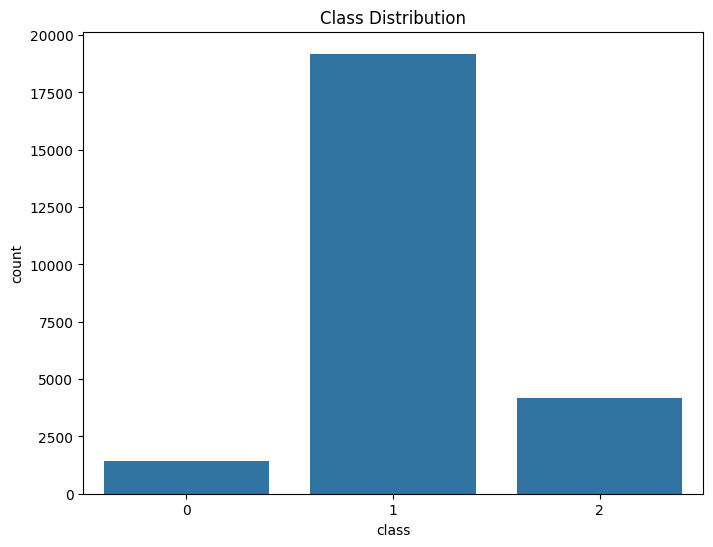

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data, x="class")
plt.title("Class Distribution")
plt.show()

**Regroup class 0 and 1 as offensive tweets and keep class 2 as normal tweets**

In [9]:
data['binary_class'] = data['class'].replace({0: 1, 1: 1, 2: 0})

print(data['binary_class'].value_counts())

binary_class
1    20620
0     4163
Name: count, dtype: int64


In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(data['cleaned_tweet'], data['binary_class'], test_size=0.2, random_state=42, stratify=data['class'])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training class distribution:", Counter(y_train))
print("Validation class distribution:", Counter(y_val))
print("Test class distribution:", Counter(y_test))

train_df = pd.DataFrame({'tweet': X_train, 'class': y_train})
val_df = pd.DataFrame({'tweet': X_val, 'class': y_val})
test_df = pd.DataFrame({'tweet': X_test, 'class': y_test})

Training class distribution: Counter({1: 16496, 0: 3330})
Validation class distribution: Counter({1: 2062, 0: 416})
Test class distribution: Counter({1: 2062, 0: 417})


In [11]:
def to_tfidf(X_train, X_val, X_test):
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)
    return X_train, X_val, X_test

In [12]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = to_tfidf(X_train, X_val, X_test)

In [13]:
rl_model = LogisticRegression()

# Train model on training set with corresponding labels
rl_model.fit(X_train_tfidf, train_df['class'])

# Predict labels for test set
y_pred_rl = rl_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_rl))

# Evaluate performances for model with accuracy
accuracy_rl = accuracy_score(y_test, y_pred_rl)
print("Accuracy:", accuracy_rl)

              precision    recall  f1-score   support

           0       0.91      0.69      0.79       417
           1       0.94      0.99      0.96      2062

    accuracy                           0.94      2479
   macro avg       0.92      0.84      0.87      2479
weighted avg       0.93      0.94      0.93      2479

Accuracy: 0.936264622831787


In [14]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_rf))

# Evaluate performances for model with accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

              precision    recall  f1-score   support

           0       0.91      0.58      0.71       417
           1       0.92      0.99      0.95      2062

    accuracy                           0.92      2479
   macro avg       0.91      0.78      0.83      2479
weighted avg       0.92      0.92      0.91      2479

Accuracy: 0.9193223073820089


## Resample for better results

In [15]:
# Separate features and target variable
X = data['cleaned_tweet'].values.reshape(-1, 1)
y = data['binary_class']

# Oversample the minority class
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=['tweet'])
df_resampled['class'] = y_resampled

# Display new class distribution
print("Resampled class distribution:", Counter(df_resampled['class']))

Resampled class distribution: Counter({0: 20620, 1: 20620})


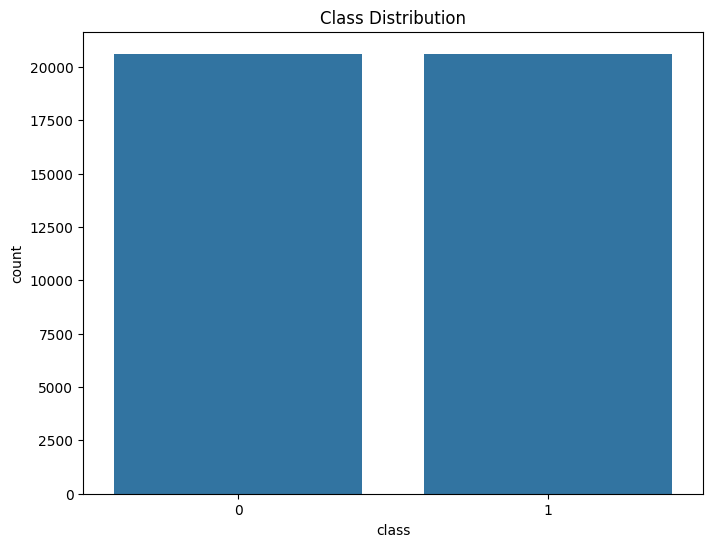

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(df_resampled, x="class")
plt.title("Class Distribution")
plt.show()

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(df_resampled['tweet'], df_resampled['class'], test_size=0.2, random_state=42, stratify=df_resampled['class'])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training class distribution:", Counter(y_train))
print("Validation class distribution:", Counter(y_val))
print("Test class distribution:", Counter(y_test))

train_df = pd.DataFrame({'tweet': X_train, 'class': y_train})
val_df = pd.DataFrame({'tweet': X_val, 'class': y_val})
test_df = pd.DataFrame({'tweet': X_test, 'class': y_test})

Training class distribution: Counter({0: 16496, 1: 16496})
Validation class distribution: Counter({1: 2062, 0: 2062})
Test class distribution: Counter({0: 2062, 1: 2062})


In [18]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = to_tfidf(X_train, X_val, X_test)

In [19]:
classifier = LogisticRegression()

# Train model on training set with corresponding labels
classifier.fit(X_train_tfidf, train_df['class'])

# Predict labels for test set
y_pred_rl = classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_rl))

accuracy_rl = accuracy_score(y_test, y_pred_rl)
print("Accuracy:", accuracy_rl)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2062
           1       0.99      0.94      0.96      2062

    accuracy                           0.96      4124
   macro avg       0.97      0.96      0.96      4124
weighted avg       0.97      0.96      0.96      4124

Accuracy: 0.9645974781765276


In [20]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_rf))

# Evaluate performances for model with accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2062
           1       1.00      0.97      0.98      2062

    accuracy                           0.98      4124
   macro avg       0.99      0.98      0.98      4124
weighted avg       0.99      0.98      0.98      4124

Accuracy: 0.9849660523763336


In [21]:
# Create pipeline with TfidfVectorizer and classification model
pipeline_rl = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Define hyperparamater grid for GridSearch
param_grid_rl = {
    'tfidf__ngram_range': [(1,1),(1,2),(2,2)],  # Utiliser des unigrammes, des bigrammes ou les deux
    'clf__C': [0.1, 1, 10],  # Paramètre de régularisation pour la régression logistique
}

# Create GridSearchCV object to do the research on hperparameters grid
grid_search_rl = GridSearchCV(pipeline_rl, param_grid_rl, cv=5, n_jobs=-1)

# Train GridSearchCV on training data
grid_search_rl.fit(train_df["tweet"], train_df['class'])

# Print best hyperparameters
print("Meilleurs paramètres:", grid_search_rl.best_params_)

# Get the best model from the grid search
best_rl = grid_search_rl.best_estimator_

# Predict labels for the test set using the best model found by GridSearchCV
y_pred_rl = best_rl.predict(test_df["tweet"])

# Print classification report to evaluate performance
print(classification_report(test_df['class'], y_pred_rl))

Meilleurs paramètres: {'clf__C': 10, 'tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2062
           1       1.00      0.96      0.98      2062

    accuracy                           0.98      4124
   macro avg       0.98      0.98      0.98      4124
weighted avg       0.98      0.98      0.98      4124



In [22]:
print(pipeline_rl.steps[0][1])

TfidfVectorizer()


In [23]:
# Create a pipeline with TfidfVectorizer and RandomForestClassifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Text vectorization step
    ('clf', RandomForestClassifier(random_state=42))  # Classifier (Random Forest)
])

# Define the parameter grid to search over
param_grid_rf = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],  # Use unigram, bigram, or both
    'clf__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'clf__max_depth': [None, 10, 20, 30],  # Max depth of the trees
    'clf__min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'clf__min_samples_leaf': [1, 2, 4],    # Minimum samples at leaf nodes
    'clf__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Assuming you have your train_df with the "tweet" and "class" columns
grid_search_rf.fit(train_df["tweet"], train_df['class'])

# Display the best parameters found by GridSearchCV
print("Best parameters:", grid_search_rf.best_params_)

# Get the best model from the grid search
best_rf = grid_search_rf.best_estimator_

# Predict labels for the test set using the best model found by GridSearchCV
y_pred_rf = best_rf.predict(test_df["tweet"])

# Print classification report to evaluate performance
print(classification_report(test_df['class'], y_pred_rf))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, tfidf__ngram_range=(1, 1); total time=  10.8s
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, tfidf__ngram_range=(1, 1); total time=  11.2s
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, tfidf__ngram_range=(1, 1); total time=  11.5s
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, tfidf__ngram_range=(1, 1); total time=  11.7s
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, tfidf__ngram_range=(1, 1); total time=  11.9s
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__min_samples_leaf=1, clf__min_s

In [24]:
# Predictions and evaluation for Logistic Regression
predictions_rl = grid_search_rl.predict(val_df["tweet"])

# Evaluate Logistic Regression performance
acc_rl = accuracy_score(y_val, predictions_rl)
prec_rl = precision_score(y_val, predictions_rl, pos_label=True)
rec_rl = recall_score(y_val, predictions_rl, pos_label=True)
f1_rl = f1_score(y_val, predictions_rl, pos_label=True)

# Display results for Logistic Regression
print("LR Performance:")
print('Accuracy:', acc_rl)
print('Precision:', prec_rl)
print('Recall:', rec_rl)
print('F1 score:', f1_rl)

LR Performance:
Accuracy: 0.978176527643065
Precision: 0.9984833164812943
Recall: 0.957807953443259
F1 score: 0.9777227722772277


In [25]:
# Predictions and evaluation for Random Forest
predictions_rf = grid_search_rf.predict(val_df["tweet"])

# Evaluate Random Forest performance
acc_rf = accuracy_score(y_val, predictions_rf)
prec_rf = precision_score(y_val, predictions_rf, pos_label=True)
rec_rf = recall_score(y_val, predictions_rf, pos_label=True)
f1_rf = f1_score(y_val, predictions_rf, pos_label=True)

# Display results for Random Forest
print("Random Forest Performance:")
print('Accuracy:', acc_rf)
print('Precision:', prec_rf)
print('Recall:', rec_rf)
print('F1 score:', f1_rf)

Random Forest Performance:
Accuracy: 0.9905431619786615
Precision: 0.9995061728395062
Recall: 0.9815712900096993
F1 score: 0.990457548323954


In [26]:
# Save the vectorizer --- Logistic Regression
with open('../models/insults/insults_tfidf_lr_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(pipeline_rl.steps[0][1], vectorizer_file)

# Save the trained model and vectorizer --- Random Forest
with open('../models/insults/insults_tfidf_rf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(pipeline_rf.steps[0][1], vectorizer_file)

# Save the trained model --- Logistic Regression
with open('../models/insults/insults_logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(best_rl, model_file)

# Save the trained model --- Random Forest
with open('../models/insults/insults_random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf, model_file)